# Description
From DCE data, it determines the arrival of CA in lungs, segment outer body, lung tissues and enhancing vessels.
Finally, it chooses target for VFA registration.

# Loads modules and packages

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import time
import numpy as np
import pylab as pl
from pynamika import *
from chanvesemaster import chanvese
from morphsnakesmaster import morphsnakes
import re
import os
import shutil
import glob
from skimage import data, io, filters, exposure
import nibabel as nib
import copy
import json
from scipy import signal
from scipy import stats
from scipy.ndimage import convolve1d
from scipy.ndimage import gaussian_laplace
from scipy.ndimage.filters import median_filter
from scipy.ndimage.measurements import maximum_position
from scipy.ndimage.measurements import center_of_mass
from scipy.ndimage.filters import maximum_filter
from scipy.ndimage.morphology import generate_binary_structure, binary_erosion
from scipy import ndimage
from skimage.morphology import binary_closing, binary_opening
from pybxd.readBxdImage import read_bxd_image
def write2StudyIndex(Path2JsonFile, Key, Value):
    sifid = open(Path2JsonFile,'r')
    study_index = json.load(sifid)
    sifid.close()
    
    study_index[Key] = Value
    
    with open(Path2JsonFile,'w') as jFile:
        json.dump(study_index, jFile)
    print('***** File {} updated *****'.format(Path2JsonFile))


# Auxiliar Functions

In [2]:
def circle_levelset(shape, center, sqradius, scalerow=1.0):
    """Build a binary function with a circle as the 0.5-levelset."""
    grid = np.mgrid[list(map(slice, shape))].T - center
    phi = sqradius - np.sqrt(np.sum((grid.T)**2, 0))
    u = np.float_(phi > 0)
    return u

In [3]:


def detect_peaks(image):
    """
    Takes an image and detect the peaks usingthe local maximum filter.
    Returns a boolean mask of the peaks (i.e. 1 when
    the pixel's value is the neighborhood maximum, 0 otherwise)
    """

    # define an 8-connected neighborhood
    neighborhood = generate_binary_structure(2,2)

    #apply the local maximum filter; all pixel of maximal value 
    #in their neighborhood are set to 1
    local_max = maximum_filter(image, footprint=neighborhood)==image
    #local_max is a mask that contains the peaks we are 
    #looking for, but also the background.
    #In order to isolate the peaks we must remove the background from the mask.

    #we create the mask of the background
    background = (image==0)

    #a little technicality: we must erode the background in order to 
    #successfully subtract it form local_max, otherwise a line will 
    #appear along the background border (artifact of the local maximum filter)
    eroded_background = binary_erosion(background, structure=neighborhood, border_value=1)

    #we obtain the final mask, containing only peaks, 
    #by removing the background from the local_max mask (xor operation)
    detected_peaks = local_max ^ eroded_background

    return detected_peaks



## Load CVS file

In [4]:
def loadImages(PATH2IMG):
    """
    
    """        
    IMFID  = nib.load(PATH2IMG)
    IMDATA = IMFID.get_data()
    
    return IMDATA

In [5]:
def ReadXTR(Path2XTR):
    
    d = {}
    with open(Path2XTR) as f:
        for line in f:
#             d=dict([line.split() for line in f]) -- It doesn't give the argument as number (i.e. float)
            (key, val) = line.split()
            d[key] = float(val)    
            
    return d

In [6]:
def MakeStdMatrix(Dyn_data,TimeInterval):
#Create a matrix which intensity depend on the movement present in Dyn_data over time (dimension 4)

    
    Dyn_data_f= Dyn_data
    #Dyn_data_f= convolve1d(Dyn_data_f,[+1,1,0,-1,-1],1)

    MeanSlice = np.nanmean(Dyn_data_f,3)
    #penalize high intensity pixels (organs), without advantage noise too much
    MeanSlice =MeanSlice/np.max(MeanSlice)+0.1
    MeanSlice[MeanSlice>1] = 1

    #Calculate the std matrix along the time dimension, but only on time interval (ie, half acquisition)
    MatrixStdCalc = np.zeros((Data.shape[0],Data.shape[1],NumberSlice ))
    for rrows in range(Data.shape[0]) :
        for ccols in range(Data.shape[1]) :
            for sslice in range(NumberSlice):
                Signal = Dyn_data_f[rrows,ccols,sslice,TimeInterval].squeeze() 
                MatrixStdCalc[rrows,ccols,sslice] = np.std(Signal)/(MeanSlice[rrows,ccols,sslice])
    #blur slightly images, bring noise and small details down            
    MatrixStdCalc1= median_filter(MatrixStdCalc,size=(3,5,1))  
    MatrixStdCalc1[MatrixStdCalc1<0]=0
    return MatrixStdCalc1


End of Section - Auxiliar Functions

# Defines path to data and performs file conversion

In [7]:
DATAID     = ['LPS030']
VISIT = 'LPS30-visit1-2014-11-14'
CONFIGNAME = 'pulmolux-oe-ms2d-config'

ServerPath   = os.path.join(os.sep, 'Volumes' , 'Data')
Path2Data       = os.path.join(os.sep, ServerPath, 'R-GSK-16-04', 'LPS-VOLUNTEER-STUDY-SCANS', DATAID[0],VISIT )
Path2Analysis    = os.path.join(Path2Data, 'Analyze')

Path2Tmp = os.path.join(Path2Data,'analysis', 'tmp')

In [8]:
DynPattern   = '_t1_DCE_tt'
T1mapPattern = '_t1__t1_tip'


In [9]:
#Find the name of each slice

DictFA={}
DictRep={}
FAnames=[]
counter=0
counterFA=0
counterRep=0
Rep_counterDyn = 0


for dataset in DATAID:
    ListOfFiles   = os.listdir(Path2Analysis)  
    for file in ListOfFiles: 
        if (file.find(T1mapPattern)>0) & file.endswith('.img') :
            if counterFA==0: #load one file, to understand the size
                Data= loadImages(os.path.join(Path2Analysis,file))
            FA_ind= (file.find('tip')) #this TI ind
            FAfile = file[FA_ind+4:FA_ind+7]
            if FAnames.count(FAfile) == 0:
                FAnames.append(FAfile)
                counterFA=counterFA+1
            Rep_ind= (file.find('tp')) #this TI ind
            Repfile = file[Rep_ind:Rep_ind+6]
            try: 
                index =int(DictRep[Repfile])
            except:
                DictRep[Repfile] = counterRep
                counterRep=counterRep+1

        if (file.find(DynPattern )>0) & file.endswith('.img') :
            Rep_ind= (file.find('tp')) #this TI ind
            Repetition = np.int(file[Rep_ind+2:Rep_ind+6])
            if Repetition>Rep_counterDyn:
                Rep_counterDyn=Repetition
print('All done. Check there are no error messages before moving to the next cells')    
NumbersFA = np.zeros((len(FAnames),1))

for FA in range(len(FAnames)):
    Num=re.findall(r'\d+',FAnames[FA])
    if int(Num[0])<15:
        NumbersFA[FA] = Num[0]
if NumbersFA[len(FAnames)-1]==0:
    NumbersFA = NumbersFA[0:len(FAnames)-1]
FAnamesA=np.array(FAnames)
print(NumbersFA)
inds = np.argsort(NumbersFA,0)
NumbersFASorted =np.sort(NumbersFA,0)
FAnamesOrdered = FAnamesA[inds]
FAnamesO=list(FAnamesOrdered )
for FA in range(FAnamesOrdered.shape[0]):
    aa =(FAnamesO[FA][0])
    DictFA[aa]=FA #dictionary ordered for TI values
print(DictRep)
print(DictFA)

All done. Check there are no error messages before moving to the next cells
[[  2.]
 [  5.]
 [ 10.]]
{'tp0002': 0, 'tp0003': 1, 'tp0004': 2, 'tp0005': 3, 'tp0006': 4}
{'2_t': 0, '5_t': 1, '10_': 2}


In [10]:
#load all file in the dynamics - Acquisition 10 - in Dyn_data and the T1 maps data in T1_data
ListOfFiles = os.listdir(Path2Analysis)
counter=-1
NAverages=len(DictRep)
NumFA= len(DictFA)

Dyn_data=np.zeros((Data.shape[0],Data.shape[1],Data.shape[2] ,Rep_counterDyn))# dim1,dim2,dim3,dyn
T1_data=np.zeros((Data.shape[0],Data.shape[1],Data.shape[2] ,NumFA,NAverages))
T1_data_reorder=np.zeros((Data.shape[0],Data.shape[1],Data.shape[2] ,NumFA*NAverages))
FileNamesVFA = np.empty((NumFA,NAverages), dtype=object)
ListOfFiles   = os.listdir(Path2Analysis) 
for file in ListOfFiles:
    if (file.find(DynPattern)>0) & file.endswith('.img') :
        DataF = loadImages(os.path.join(Path2Analysis,file));
        counter=counter+1
        Dyn_data[:,:,:,counter]= DataF.squeeze() 
    if (file.find(T1mapPattern)>0) & file.endswith('.img') :
        DataF = loadImages(os.path.join(Path2Analysis,file));
        FA_ind= (file.find('tip')) #this TI ind
        FAfile = file[FA_ind+4:FA_ind+7]
        try:
            indexFA =int(DictFA[FAfile])
            Rep_ind= (file.find('tp')) #this TI ind
            Repfile = file[Rep_ind:Rep_ind+6]
            indexRep = int(DictRep[Repfile])
            T1_data[:,:,:,indexFA,indexRep ]= DataF.squeeze()
            T1_data_reorder[:,:,:,indexFA*NAverages+indexRep ]= DataF.squeeze()# dim1,dim2,dim3,TI*rep
            FileNamesVFA[indexFA, indexRep]= file
        except:
            print()

IndexError: index 140 is out of bounds for axis 3 with size 140

Find the diaphragm position

In [11]:

NumberSlice= Dyn_data.shape[2]
#Calculate the std matrix along the time dimension, without the first part presenting the first pass
TimeInterval = (np.arange(Dyn_data.shape[3]-30,np.int(np.ceil(Dyn_data.shape[3])),1))

MatrixStd =  MakeStdMatrix(Dyn_data,TimeInterval)




In [12]:
# 2d segmentation Chan-Vese
InitMask = np.ones((Dyn_data.shape[0],Dyn_data.shape[1]))
Segmentation = np.zeros((Dyn_data.shape[0],Dyn_data.shape[1],Dyn_data.shape[2]))
start = time.time()
for sslice in range (Dyn_data.shape[2]):
    seg = chanvese.chanvese( Dyn_data[:,:,sslice,0].squeeze(), InitMask , max_its=1000, alpha=0.4, thresh=0, color='r', display=False)
    Segmentation[:,:,sslice] = seg[0]
end = time.time()
print(end-start)

97.6076180934906


In [13]:
# 2d segmentation snakes
SegmentationNew = np.zeros((Dyn_data.shape[0],Dyn_data.shape[1],Dyn_data.shape[2]))
start = time.time()
for sslice in range (Dyn_data.shape[2]):
    img = Dyn_data[:,:,sslice,0].squeeze()
    macwe = morphsnakes.MorphACWE(img, smoothing=6, lambda1=4, lambda2=4)
    macwe.levelset = circle_levelset(img.shape, (64,64), 84)
    morphsnakes.evolve_Novisual(macwe, num_iters=2)
    SegmentationNew[:,:,sslice] = macwe.levelset
end = time.time()
print(end-start)

0.7732870578765869


In [14]:
# 3d segmentation snakes
img = Dyn_data[:,:,:,0].squeeze()
start = time.time()
macwe = morphsnakes.MorphACWE(img, smoothing=4, lambda1=5, lambda2=10)
macwe.levelset = circle_levelset(img.shape, (64, 64, 11),84)
    
    # Visual evolution.
morphsnakes.evolve_Novisual(macwe, num_iters=20)
Segmentation3dOut=macwe.levelset
end = time.time()
print(end-start)

11.632248878479004


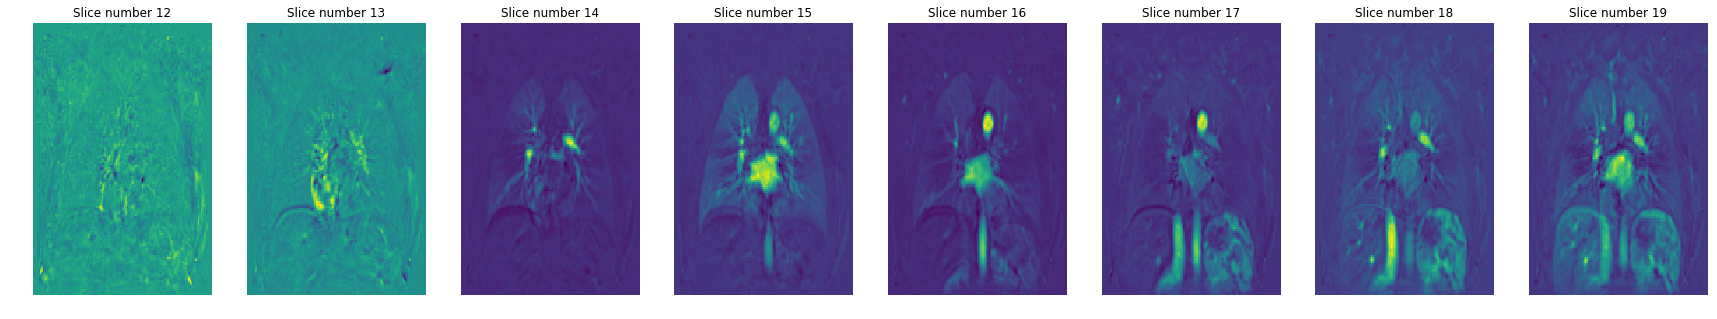

In [15]:
nrows=1
ncols=8
plt.figure( figsize=(30,5))
for i in range(8) :
    Slice = Dyn_data[:,:,15,i+12] - Dyn_data[:,:,15,8]
    ax = plt.subplot(nrows,ncols,i+1)
    im=plt.imshow(np.rot90(Slice,1), aspect="auto")
    plt.axis('off')
    plt.title('Frame number {0:.0f}'.format(i+12))

Injection point
14


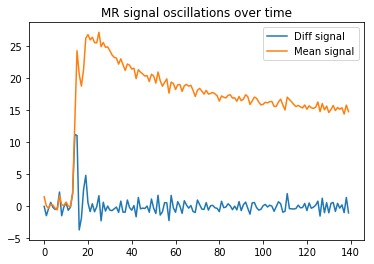

In [26]:
#find injection peak
MeanDyn = np.zeros((Dyn_data.shape[3],1))
dd = np.zeros((Dyn_data.shape[3],1))
for ii in range (Dyn_data.shape[3]):
    MeanDyn[ii] = np.nanmean((Dyn_data[:,:,5:15, ii] - np.nanmean(Dyn_data[:,:,5:15, 1:6],3)) *Segmentation3dOut[:,:,5:15])
    if ii>0:
        dd[ii] = MeanDyn[ii] - MeanDyn[ii-1]
plt.figure()
plt.plot(dd, label='Diff signal')
plt.plot(MeanDyn, label='Mean signal')
plt.legend()
plt.title('MR signal oscillations over time')
MaxP=np.argmax(dd)
print('Injection point')
print(MaxP)


324404
52.2


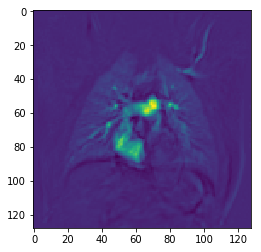

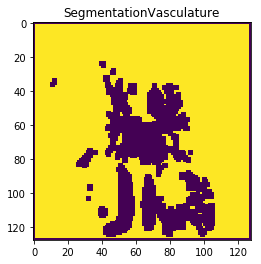

In [28]:
plt.figure()
plt.imshow(np.rot90(Dyn_data[:,:,10, MaxP] -np.nanmean(Dyn_data[:,:,10, 1:6],2)  ))
SegmentationVasculature = np.ones((128,128,22))
#Make a mask of vasculature based on early enhancement
DataAroundPeak=np.mean(Dyn_data[:,:,:,MaxP:MaxP+5],3) - np.mean(Dyn_data[:,:,:,2:MaxP-2],3)
plt.figure()
n, bins, patches = plt.hist(DataAroundPeak.flatten(), 20, normed=True)
Dyn_dataT_f = DataAroundPeak.flatten()
Sorted = np.sort(Dyn_dataT_f)
Value = np.int(np.ceil(0.90 * np.ceil(Dyn_dataT_f.shape)))
print(Value)
Treshold = Sorted[Value]
print(Treshold)
SegmentationVasculature[ DataAroundPeak>Treshold]=0

SegmentationVasculature = binary_erosion(SegmentationVasculature, structure=np.ones((3,3,2)))
#SegmentationVasculature = binary_closing(SegmentationVasculature[:,:,:], np.ones(4,4,1))
plt.title('SegmentationVasculature')
plt.imshow(np.rot90(SegmentationVasculature[:,:,15]))

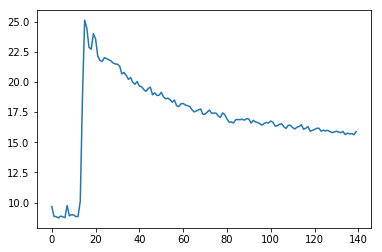

In [29]:
MeanDynV = np.zeros((Dyn_data.shape[3],1))
for ii in range (Dyn_data.shape[3]):
    MeanDynV[ii] = np.nanmean(Dyn_data[:,:,:,ii]*(1-SegmentationVasculature))
    
plt.plot(MeanDynV)

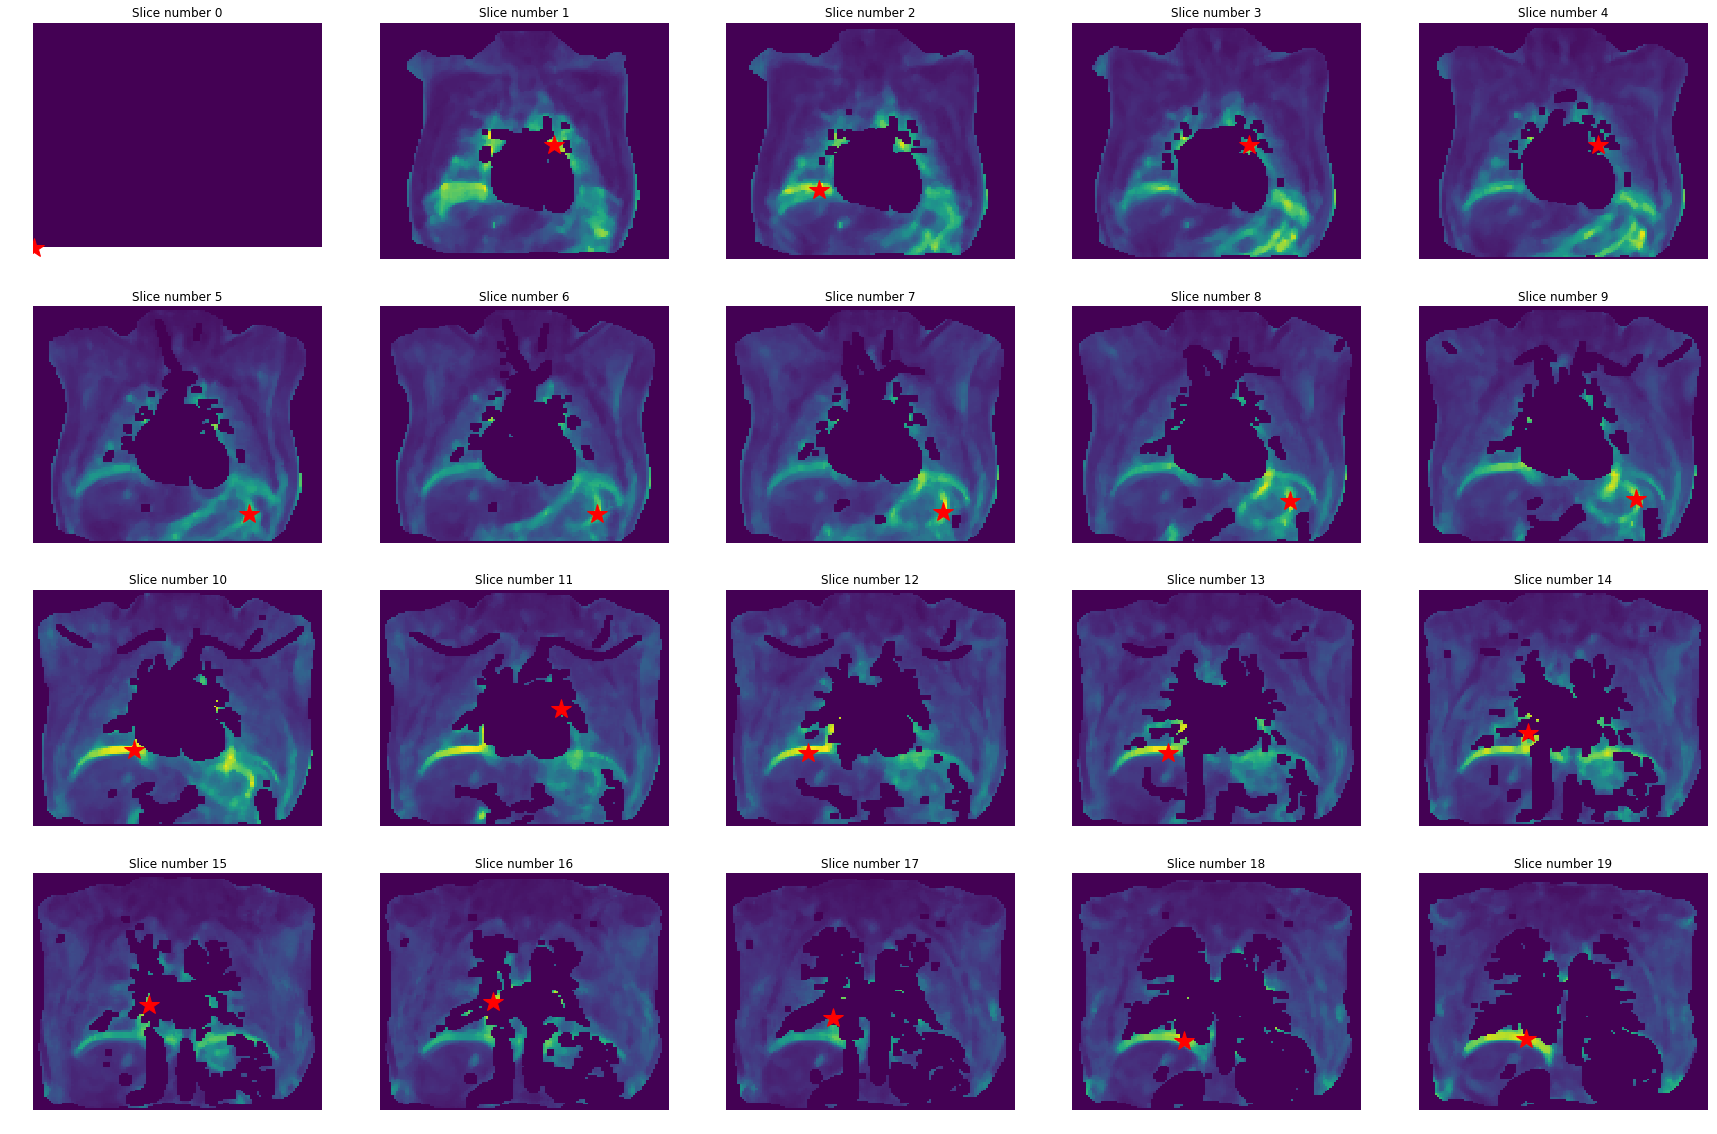

In [30]:
MatrixStd =MatrixStd  * Segmentation3dOut*SegmentationVasculature
#Display results
nrows=4
ncols=Dyn_data.shape[2]/4
plt.figure( figsize=(30,20))
for i in range(20) :
    Slice = MatrixStd[:,:,i]
    ax = plt.subplot(nrows,ncols,i+1)
    im=plt.imshow(np.rot90(Slice,1), aspect="auto")
    MaxPos = maximum_position(MatrixStd[:,:,i ])
    plt.plot(MaxPos[0], MatrixStd.shape[0] - MaxPos[1], 'r*',  markersize=20)
    plt.axis('off')
    plt.title('Slice number {0:.0f}'.format(i))

/usr/local/lib/python3.6/site-packages/ipykernel/__main__.py:14: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/site-packages/scipy/ndimage/measurements.py:1301: RuntimeWarning: invalid value encountered in double_scalars
  for dir in range(input.ndim)]


(128, 128, 22)


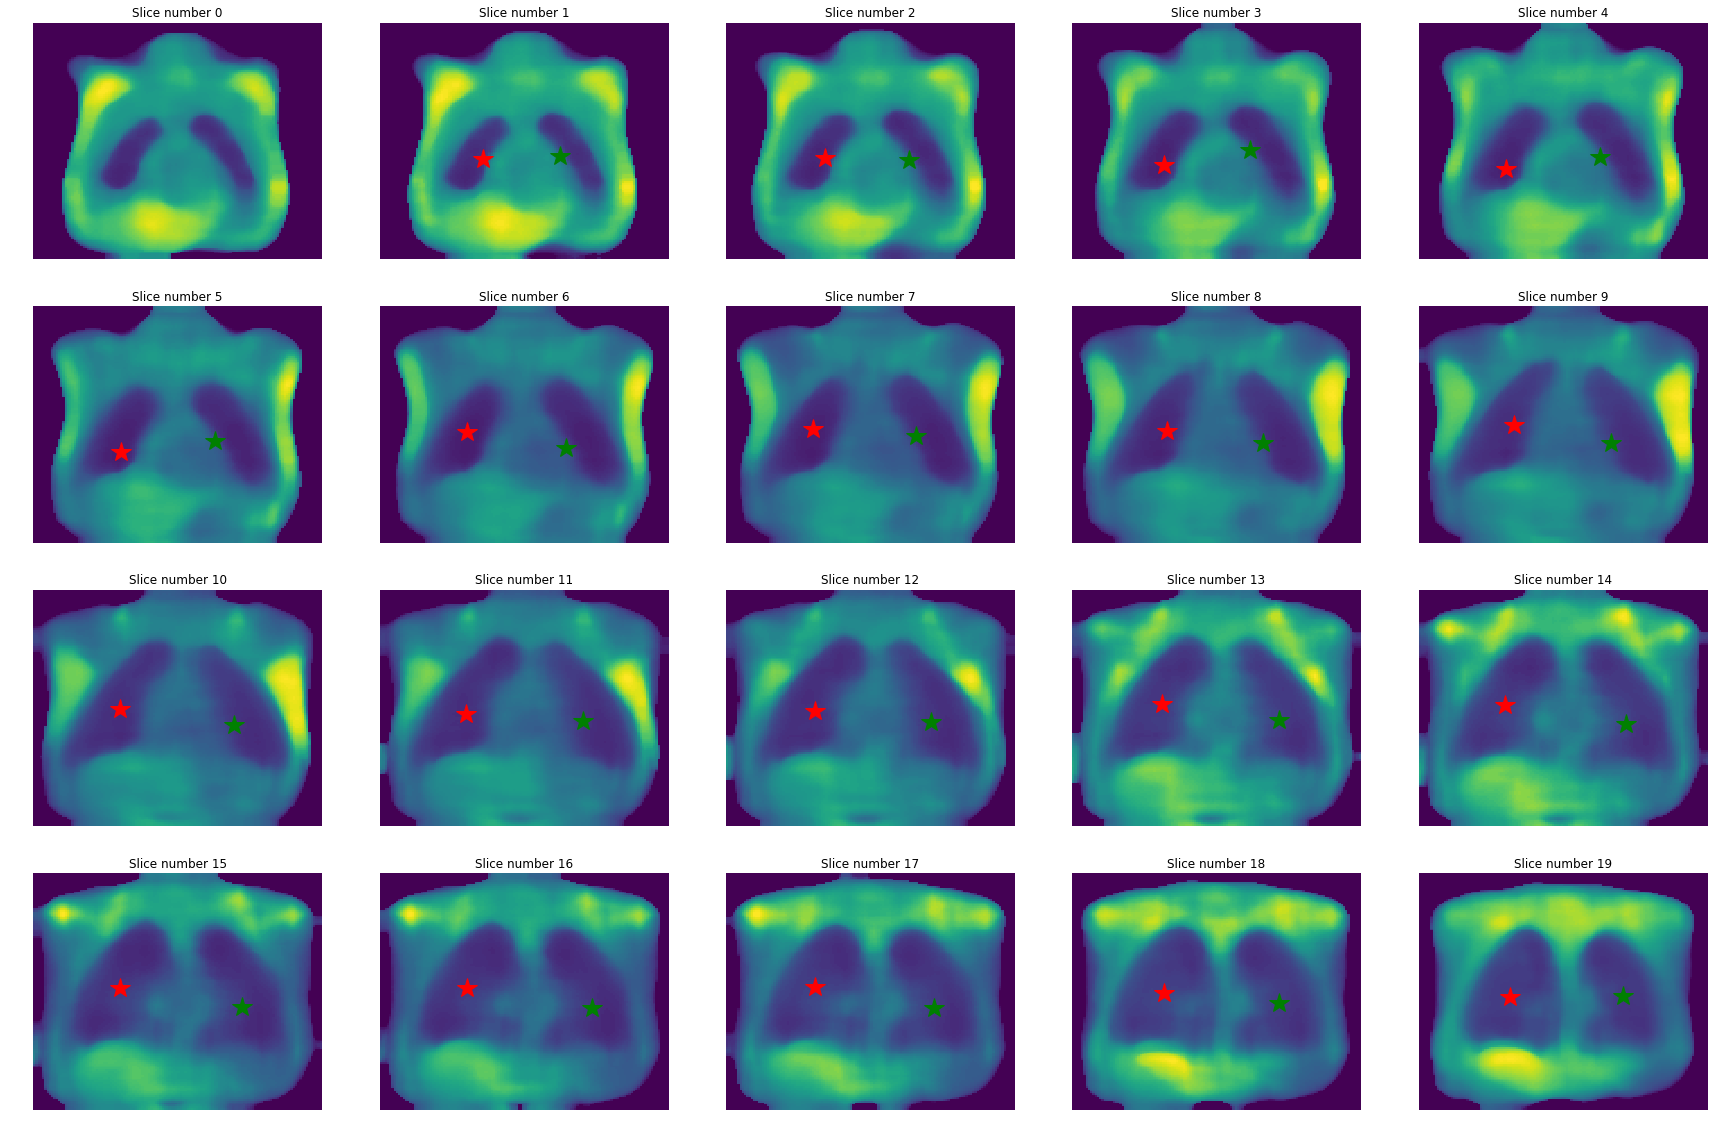

In [31]:


Segmentation3dOut_E = binary_erosion(Segmentation3dOut, structure=np.ones((5,5,2)))
filt= median_filter(Segmentation3dOut*img,size=(15,15,5))
PP = np.zeros((Dyn_data.shape[0],Dyn_data.shape[1],Dyn_data.shape[2]))
Peaks = np.zeros((Dyn_data.shape[0],Dyn_data.shape[1],Dyn_data.shape[2]))
CoMup = np.zeros((2,Dyn_data.shape[2]))
CoMdown = np.zeros((2,Dyn_data.shape[2]))
for ss in range(Dyn_data.shape[2]):
    Inv = 1-  filt[:,:,ss]/np.max(filt[:,:,ss])
    Inv[Segmentation3dOut[:,:,ss]==0] = np.nan
    MeanInv = np.nanmean(Inv)*1
    Peaks1 = detect_peaks(Inv)
    Peaks1[Inv<MeanInv ] =0
    Peaks1[Segmentation3dOut_E[:,:,ss]==0 ] =0
    PP[:,:,ss] = Peaks1
    #PP[:,:,ss] = binary_opening(PP[:,:,ss], np.ones((2,2)))
    PP[:,:,ss] = binary_closing(PP[:,:,ss], np.ones((2,2)))
    CoMup[:,ss] = center_of_mass(PP[1:np.int(Dyn_data.shape[0]/2-1),:,ss ])
    CoMdown[:,ss] = center_of_mass(PP[np.int(Dyn_data.shape[0]/2+1):np.int(Dyn_data.shape[0]),:,ss ]) 
    CoMdown[0,ss] = CoMdown[0,ss]+np.int(Dyn_data.shape[0]/2+1)
    
print(Peaks.shape)
nrows=4
ncols=Dyn_data.shape[2]/4
plt.figure( figsize=(30,20))
for i in range(20) :
    Slice =filt[:,:, i]
    Slice[Slice<MeanInv]=0
    ax = plt.subplot(nrows,ncols,i+1)
    im=plt.imshow(np.rot90(Slice,1), aspect="auto")
    MaxPos =  CoMup[:,i]
    plt.plot(MaxPos[0], img.shape[0] - MaxPos[1], 'r*',  markersize=20)
    MaxPos1 = CoMdown[:,i]
    plt.plot(MaxPos1[0], img.shape[0] - MaxPos1[1], 'g*',  markersize=20)
    plt.axis('off')
    plt.title('Slice number {0:.0f}'.format(i))


In [33]:
#del Segmentation3d
img = Dyn_data[:,:,:,0].squeeze()

start = time.time()
macwe = morphsnakes.MorphACWE(img, smoothing=3, lambda1=1, lambda2=1)
Nslice = 12
macwe.levelset = circle_levelset(img.shape, (CoMup[0,Nslice], CoMup[1,Nslice], Nslice),15)
    
    # Visual evolution.
morphsnakes.evolve_Novisual(macwe, num_iters=100)
Segmentation3d=macwe.levelset
end = time.time()
print(end-start)

47.69490098953247


In [34]:
start = time.time()
macwe = morphsnakes.MorphACWE(img, smoothing=3, lambda1=1, lambda2=1)
macwe.levelset = circle_levelset(img.shape, (CoMdown[0,Nslice], CoMdown[1,Nslice], Nslice),15)
    
    # Visual evolution.
morphsnakes.evolve_Novisual(macwe, num_iters=100)
Segmentation3d=macwe.levelset + Segmentation3d
end = time.time()
print(end-start)

45.58941078186035


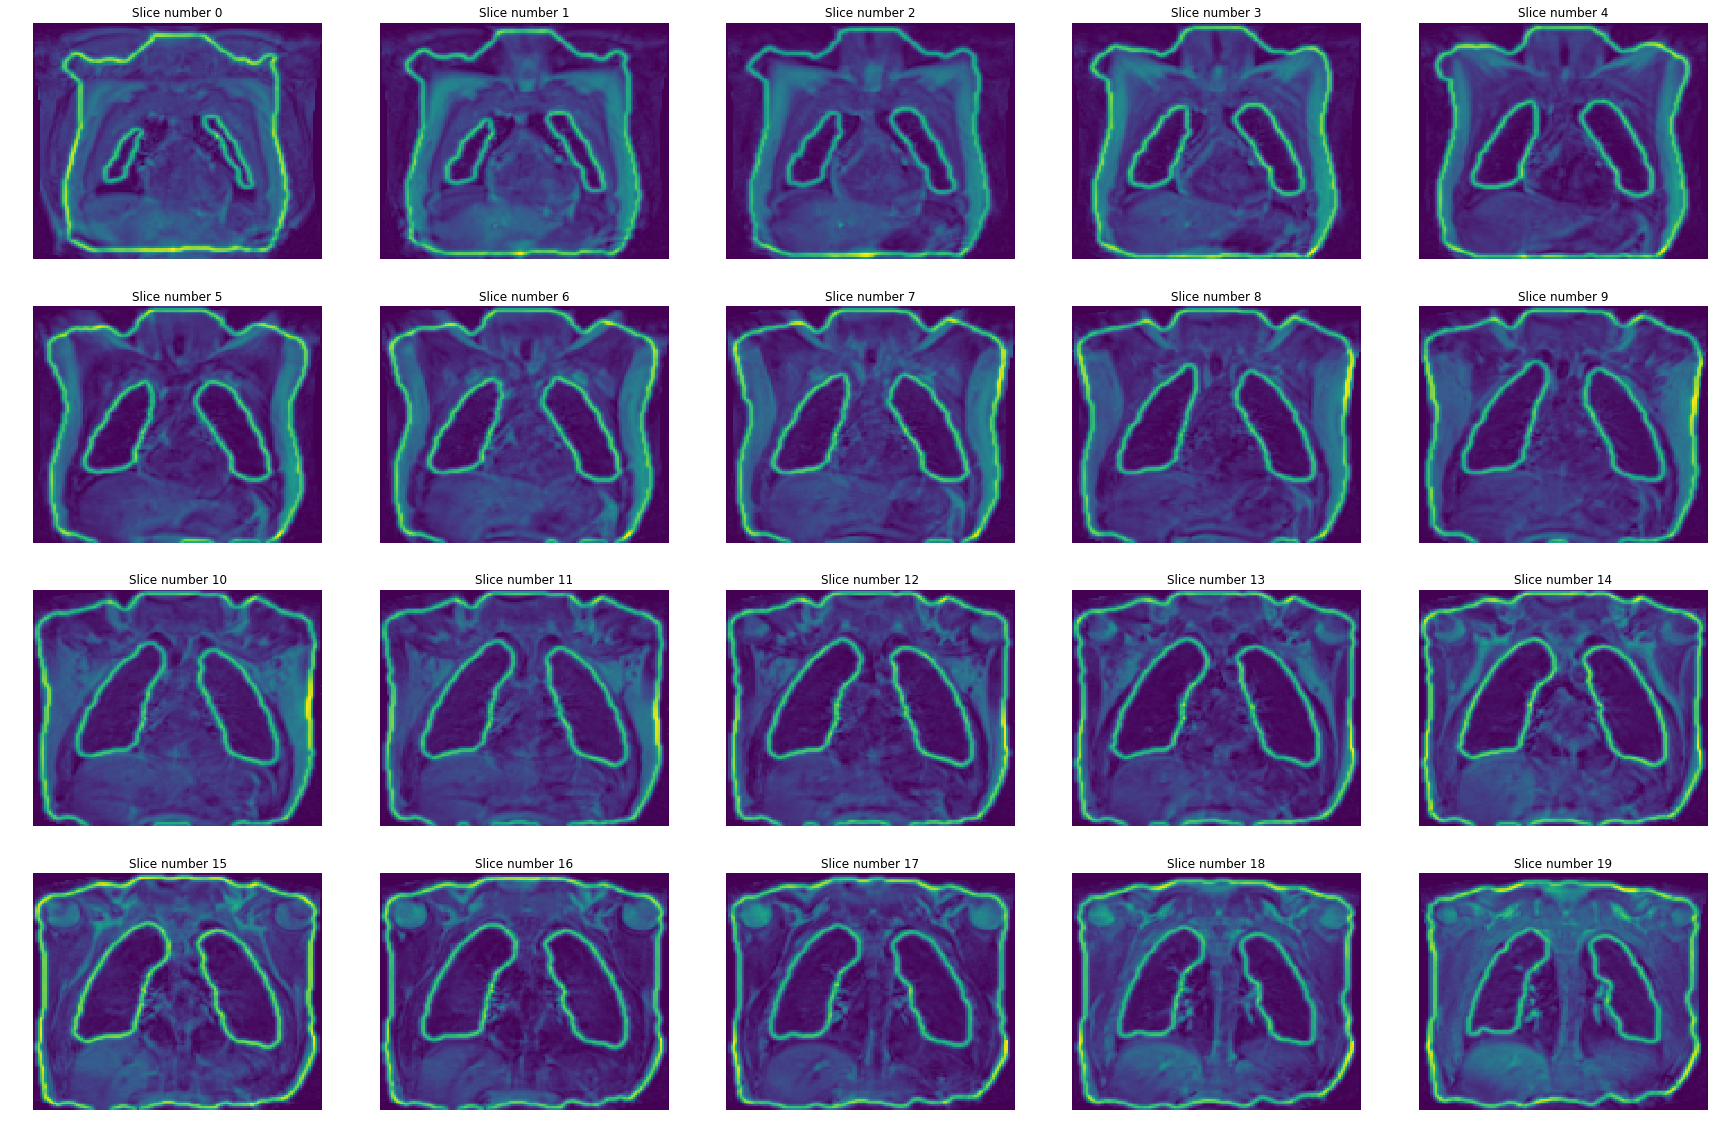

In [35]:
nrows=4
ncols=Dyn_data.shape[2]/4
plt.figure( figsize=(30,20))
for i in range(20) :
    Slice = ndimage.gaussian_gradient_magnitude(Segmentation3dOut[:,:,i],1)*500+ndimage.gaussian_gradient_magnitude(Segmentation3d[:,:,i],1)*500+img[:,:,i]
    ax = plt.subplot(nrows,ncols,i+1)
    im=plt.imshow(np.rot90(Slice,1), aspect="auto")
    plt.axis('off')
    plt.title('Slice number {0:.0f}'.format(i))

Select the slice to work with - generally last one. Is the red dot indicating the diaphragm?


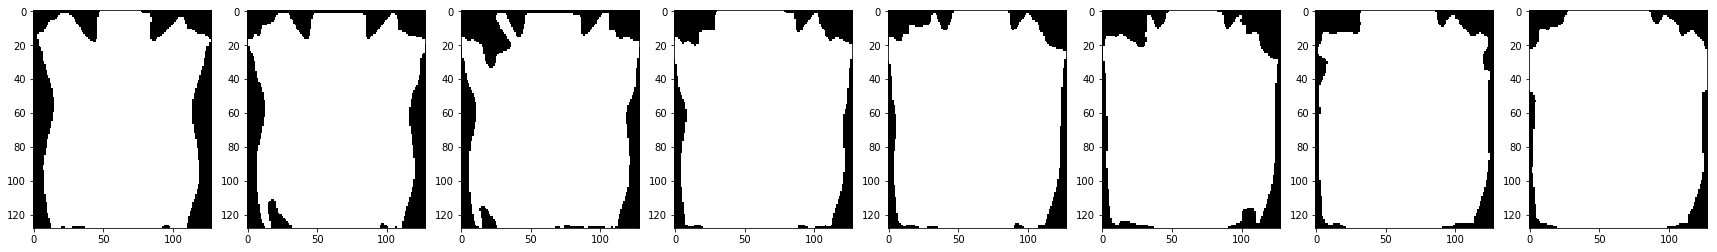

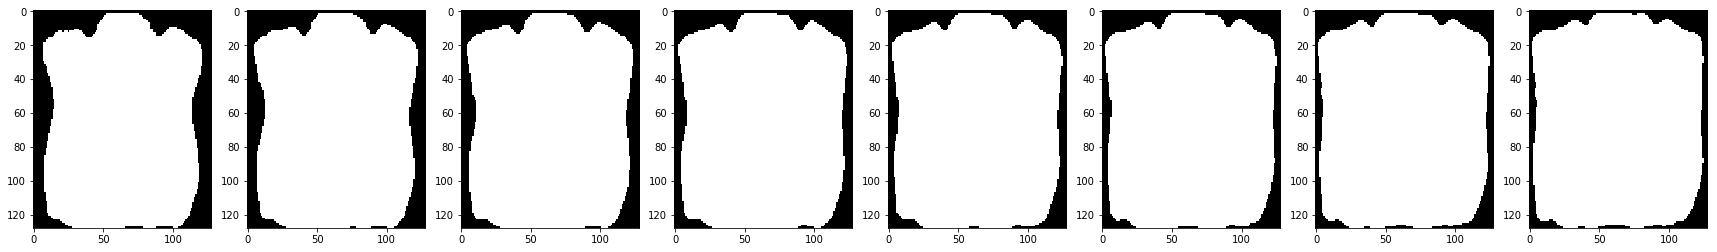

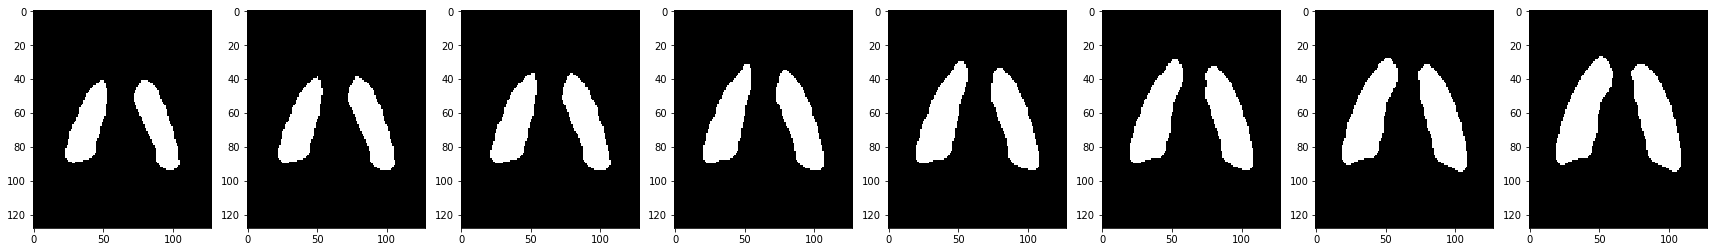

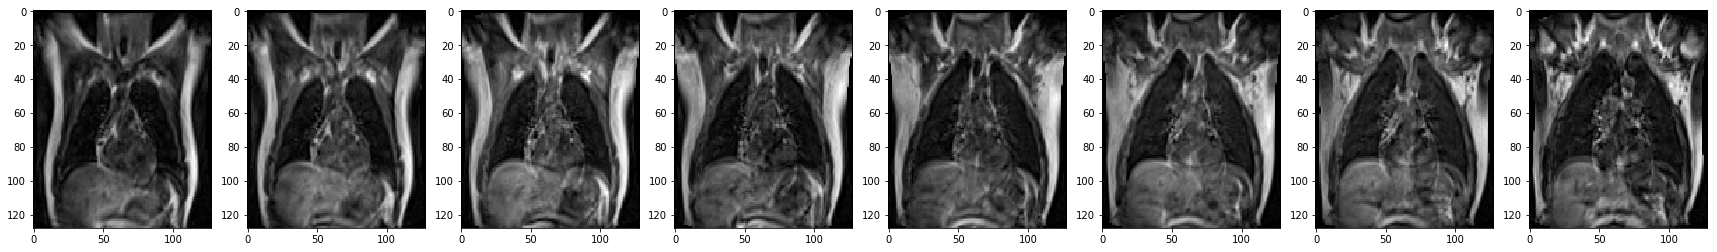

In [36]:
NumberSlice=8
nrows=1
ncols=NumberSlice
plt.figure( figsize=(30,4))
for i in range(5,NumberSlice+5,1) :
    Slice = Segmentation[:,:,i]
    ax = plt.subplot(nrows,ncols,i+1-5)
    im=plt.imshow(np.rot90(Slice,1), aspect="auto", cmap='gray')
plt.figure( figsize=(30,4))
for i in range(5,NumberSlice+5,1) :
    Slice = Segmentation3dOut[:,:,i]
    ax = plt.subplot(nrows,ncols,i+1-5)
    im=plt.imshow(np.rot90(Slice,1), aspect="auto", cmap='gray')
plt.figure( figsize=(30,4))
for i in range(5,NumberSlice+5,1):
    Slice = Segmentation3d[:,:,i]
    ax = plt.subplot(nrows,ncols,i+1-5)
    im=plt.imshow(np.rot90(Slice,1), aspect="auto", cmap='gray')
plt.figure( figsize=(30,4))
for i in range(5,NumberSlice+5,1) :
    Slice = Dyn_data[:,:,i,0]
    ax = plt.subplot(nrows,ncols,i+1-5)
    im=plt.imshow(np.rot90(Slice,1), aspect="auto", cmap='gray')

In [37]:
SliceNum =13
#The position of the diaphgram is chosen as the highest value in the selected slice
PosDiaph = maximum_position(MatrixStd[:,:,SliceNum ]) #max of the variation!
Positions=np.zeros((NAverages*NumFA ))
#We need to select a (vertical) interval around which to search for the actual diaphragm position in each slice and each repetition
VerticalIntervalAroundD = 30
#A second interval is identified for a second round of selection in 'difficult' images (ie, TI=300 ms)
#To increase SNR we can avarage in the orizontal direction - diaphragm should be quite flat at apex
HorizontalIntervalAroundD = 4


Navigator = T1_data_reorder[PosDiaph[0]-HorizontalIntervalAroundD :PosDiaph[0] +HorizontalIntervalAroundD ,PosDiaph[1]-VerticalIntervalAroundD :PosDiaph[1]+VerticalIntervalAroundD,SliceNum,:]
#average in the orizontal direction
Nav = np.array(np.mean(Navigator,0))
#First derivative along vertical dimension
Diff = np.diff(Nav,axis = 0)
#Lung Liver interface is the minimum of the first derivative
Positions[:] = np.argmin(Diff,0) #Lung Liver interface

#choose most common position, without considering less interesting TI  =300ms
MostCommon,a= stats.mode(Positions[:],0)
Distances =np.abs(Positions-MostCommon[0])

#find which acquisition has the diaphragm in the right position or close there
Target =np.zeros((NumFA))


for FA in range(NumFA):
        Target[FA] = np.argmin(Distances[FA*NAverages:FA*NAverages+NAverages]) +1
                                        


[ 1.  1.  1.]
M_sn000004_tp0002_t1__t1_tip02_tt000nan.img
M_sn000010_tp0002_t1__t1_tip_5_tt000nan.img
M_sn000016_tp0002_t1__t1_tip_10__tt000nan.img


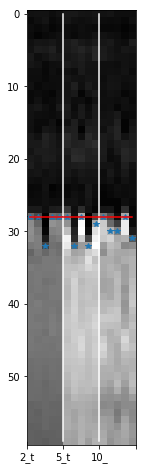

In [38]:
Navigator = T1_data_reorder[PosDiaph[0]-HorizontalIntervalAroundD :PosDiaph[0] +HorizontalIntervalAroundD ,PosDiaph[1]-VerticalIntervalAroundD :PosDiaph[1]+VerticalIntervalAroundD,SliceNum,:]
#average in the orizontal direction
Nav = np.array(np.mean(Navigator,0))
plt.figure( figsize=(8,8))
fig= plt.imshow(np.flip(Nav,0), cmap='gray')
ax = plt.gca();
#make a grid
for nTI in range(NumFA):
    plt.plot(np.ones((VerticalIntervalAroundD*2,1))*NAverages*nTI-0.5, np.arange(0,VerticalIntervalAroundD*2,1), 'w')
plt.plot((VerticalIntervalAroundD*2-1)- Positions[:],'*')
ax.set_xticks(np.arange(-0.5, NAverages*NumFA , NAverages))
ax.set_xticklabels(DictFA.keys());
Line = np.ones((NumFA*NAverages,1))*np.int( MostCommon[0])
plt.plot((VerticalIntervalAroundD*2-1)- Line,'r-')

ReferenceFileNames = np.empty((NumFA), dtype=object)
print(Target)
for FA in range(NumFA):
    ind = int(Target[FA])
    print(FileNamesVFA[FA,ind-1])
    ReferenceFileNames[FA] = FileNamesVFA[FA,ind-1]
  
SaveTargetNames = os.path.join(Path2Data, 'TargetsForRegistration')
np.save(SaveTargetNames,ReferenceFileNames)

In [39]:
TargList = [list(map(int,xt)) for xt in Target]
PIPELINECONTROLLERCONFIG ={}
PIPELINECONTROLLERCONFIG['PERSLICE']= {"ref_slices": '{}'.format(snxxx)}
print('PERSLICE')
for sl, iList in zip(DictSl, TargList): 
    PIPELINECONTROLLERCONFIG['PERSLICE'].update({'image_index_{}'.format(sl): ' '.join(list(map(str,iList)))})
print(PIPELINECONTROLLERCONFIG)
#     print('\tImg Ind {}:\t{}'.format(sl, iList))
print('\tRef Slice:\t{}'.format(snxxx))
write2StudyIndex(os.path.join(Path2Analysis, 'study-index_try.json'), 
                 'pipelineControllerConfig',
                 PIPELINECONTROLLERCONFIG) 


TypeError: 'numpy.float64' object is not iterable

Check the chosen images 

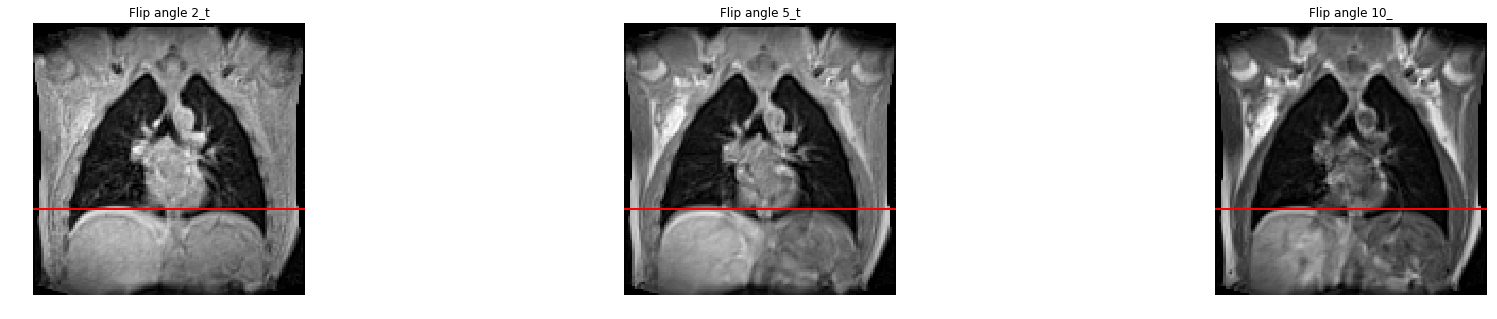

In [40]:
plt.figure( figsize=(30,5))
for i in range(NumFA):
        ind = int(Target[i]-1)
        Slice =  T1_data[:,:,SliceNum,i,ind ]
        Slice = Slice.squeeze()
        ax = plt.subplot(1,NumFA,i+1)
        im=plt.imshow(np.rot90(Slice,1), cmap='gray')
        Line = np.ones((Data.shape[0],1))*np.int( Data.shape[0] - PosDiaph[1] +(VerticalIntervalAroundD-MostCommon[0]) )
        plt.plot( Line,'r-', linewidth=2)
        plt.axis('off')
        for key, value in DictFA.items():
            if value == i:
                plt.title('Flip angle {0:s}'.format(key ))
